In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import finufft
import time
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential
from kernels.matern import Matern
import math
from torch.profiler import profile, record_function, ProfilerActivity
import pytorch_finufft.functional as pff
from efgp1d import efgp1d, efgp1d_NUFFT, efgp1d_gradient_batched, compute_convolution_vector_vectorized
from efgp_1d_dense import efgp1d_dense
from typing import Dict, Optional, Callable, Tuple
from cg import ConjugateGradients, BatchConjugateGradients
from efgp1d import _cmplx
from typing import Optional, Tuple, Dict
import pytorch_finufft.functional as pff
from torch.fft import fftn, ifftn

import warnings
warnings.filterwarnings("ignore", message=".*disabling cuda.*")


In [5]:


# --- Parameters ---
n = 20  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale =3
true_variance = 2
true_noise_variance = 0.2
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 50
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

# --- Define Mean and Covariance Functions (using PyTorch) ---
def mean_func_torch(x):
    """Mean function (returns zero vector)."""
    # Make sure output shape matches input batch shape if any
    return torch.zeros(x.shape[0], dtype=x.dtype, device=x.device)

# Squared Exponential Kernel Function for d-dimensional inputs
def squared_exponential_kernel(x1, x2, length_scale=1.0, variance=1.0):
    """
    Squared Exponential kernel using PyTorch.
    Calculates variance * exp(-0.5 * ||x1 - x2||^2 / length_scale^2)
    Handles multi-dimensional (n, d) inputs.
    """
    # Compute pairwise squared Euclidean distances
    # dist_sq = ||a - b||^2 = ||a||^2 - 2a^T b + ||b||^2
    sum_sq_x1 = torch.sum(x1**2, dim=1, keepdim=True)  # Shape (n, 1)
    sum_sq_x2 = torch.sum(x2**2, dim=1)                # Shape (m,)
    cross_term = torch.matmul(x1, x2.T)                # Shape (n, m)

    # sq_dist shape: (n, 1) + (m,) - 2 * (n, m) -> broadcasting -> (n, m)
    sq_dist = sum_sq_x1 + sum_sq_x2 - 2 * cross_term

    # Ensure squared distances are non-negative (due to potential floating point inaccuracies)
    sq_dist = torch.clamp(sq_dist, min=0.0)

    # Compute the Squared Exponential kernel
    cov = variance * torch.exp(-0.5 * sq_dist / length_scale**2)
    return cov

# --- Optimized Sampling Function ---
def sample_gp_fast(x, mean_func, cov_func, num_samples, length_scale, variance, noise_variance):
    """
    Samples efficiently from a d-dimensional Gaussian Process by pre-computing
    the Cholesky decomposition of the noisy covariance matrix.

    Parameters:
    x : torch.Tensor (n, d)
        Input points in d-dimensional space.
    mean_func : callable
        Mean function.
    cov_func : callable
        Covariance function (kernel).
    num_samples : int
        Number of samples to draw.
    length_scale : float
        Kernel length scale.
    variance : float
        Kernel variance.
    noise_variance : float
        Variance of the observation noise.

    Returns:
    torch.Tensor (n, num_samples)
        Samples from the GP at the input points x.
    """
    n_points = x.shape[0]
    mean = mean_func(x)  # Shape (n_points,)

    # 1. Compute Covariance Matrix K
    K = cov_func(x, x, length_scale=length_scale, variance=variance)  # (n_points, n_points)

    # 2. Add Noise Variance to Diagonal
    K_noisy = K + noise_variance * torch.eye(n_points, dtype=x.dtype, device=x.device)

    # 3. Compute Cholesky Factor L (K_noisy = L L^T)
    try:
        L = torch.linalg.cholesky(K_noisy)  # (n_points, n_points), lower triangular
    except torch.linalg.LinAlgError as e:
        print(f"Cholesky decomposition failed: {e}")
        # Fallback with jitter
        jitter = 1e-6 * torch.eye(n_points, dtype=x.dtype, device=x.device)
        try:
            L = torch.linalg.cholesky(K_noisy + jitter)
            print("Cholesky succeeded after adding jitter.")
        except torch.linalg.LinAlgError as e2:
            print(f"Cholesky decomposition failed even with jitter: {e2}")
            raise RuntimeError("Could not compute Cholesky decomposition.") from e2

    # 4. Efficient Sampling
    # Draw standard normal samples Z ~ N(0, I)
    Z = torch.randn(n_points, num_samples, dtype=x.dtype, device=x.device)  # (n_points, num_samples)

    # Compute samples: Y = mean + L @ Z
    samples = mean.unsqueeze(1) + L @ Z  # (n_points, num_samples)

    return samples

# --- Generate Samples ---
print(f"Generating {1} sample for n={n} points in {d} dimensions...")
start_time = time.time()

# Sample using the optimized function
y = sample_gp_fast(
    x,
    mean_func_torch,
    squared_exponential_kernel,
    num_samples=1,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
).flatten()

end_time = time.time()
print(f"Generated sample of size {y.shape[0]}.")
print(f"Time taken: {end_time - start_time:.4f} seconds")


# kernel = SquaredExponential(dimension=1, lengthscale=torch.tensor([0.5*1e-2]), variance=torch.tensor(1.0))


Using device: cpu
Generating 1 sample for n=20 points in 2 dimensions...
Generated sample of size 20.
Time taken: 0.0007 seconds


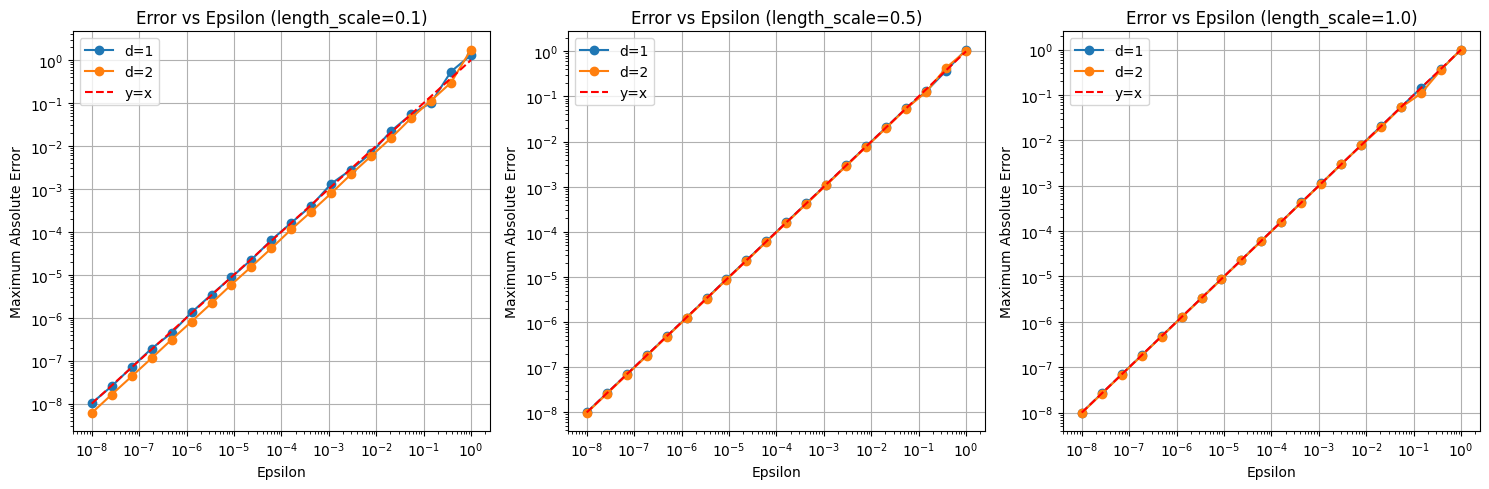


Dimension 1, length_scale 0.1:
Epsilon: 1.00e-08, Error: 9.82e-09
Epsilon: 2.64e-08, Error: 2.59e-08
Epsilon: 6.95e-08, Error: 6.84e-08
Epsilon: 1.83e-07, Error: 1.80e-07
Epsilon: 4.83e-07, Error: 4.75e-07
Epsilon: 1.27e-06, Error: 1.25e-06
Epsilon: 3.36e-06, Error: 3.30e-06
Epsilon: 8.86e-06, Error: 8.71e-06
Epsilon: 2.34e-05, Error: 2.29e-05
Epsilon: 6.16e-05, Error: 6.06e-05
Epsilon: 1.62e-04, Error: 1.60e-04
Epsilon: 4.28e-04, Error: 4.23e-04
Epsilon: 1.13e-03, Error: 1.11e-03
Epsilon: 2.98e-03, Error: 2.99e-03
Epsilon: 7.85e-03, Error: 7.75e-03
Epsilon: 2.07e-02, Error: 1.96e-02
Epsilon: 5.46e-02, Error: 5.38e-02
Epsilon: 1.44e-01, Error: 1.08e-01
Epsilon: 3.79e-01, Error: 3.61e-01
Epsilon: 1.00e+00, Error: 1.01e+00

Dimension 2, length_scale 0.1:
Epsilon: 1.00e-08, Error: 9.82e-09
Epsilon: 2.64e-08, Error: 2.59e-08
Epsilon: 6.95e-08, Error: 6.84e-08
Epsilon: 1.83e-07, Error: 1.80e-07
Epsilon: 4.83e-07, Error: 4.75e-07
Epsilon: 1.27e-06, Error: 1.25e-06
Epsilon: 3.36e-06, Error: 

In [7]:
# Test different epsilon values and record errors for d=1,2
epsilons = torch.logspace(-8, 0, 20)  # 20 points from 1e-8 to 1
length_scales = [0.1, 0.5, 1.0]  # Different length scales to test
n = 500
plt.figure(figsize=(15, 5))

for length_scale_idx, ls in enumerate(length_scales):
    plt.subplot(1, 3, length_scale_idx + 1)
    
    for d in [1, 2]:
        x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1
        errors = []
        
        kernel = SquaredExponential(dimension=d, lengthscale=torch.tensor([ls]), variance=torch.tensor(true_variance))
        
        # For d=2, expand x to 2D by duplicating coordinates
        # if d == 2:
        #     x_2d = torch.stack([x.flatten(), x.flatten()], dim=1)
        #     x_all = x_2d
        # else:
        #     x_all = x
        x_all = x
            
        x0 = x_all.min(dim=0).values  
        x1 = x_all.max(dim=0).values  

        domain_lengths = x1 - x0
        L = domain_lengths.max()
        N = x_all.shape[0]

        # Get true kernel matrix once
        kernel_matrix = kernel.kernel_matrix(x_all, x_all)

        for EPSILON in epsilons:
            # Get quadrature nodes and weights for this epsilon
            xis_1d, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=True, l2scaled=False)
            # print(mtot)
            # Make tensor product grid
            grids = torch.meshgrid(*(xis_1d for _ in range(d)), indexing='ij')
            xis = torch.stack(grids, dim=-1).view(-1, d)

            
            # Get weights
            ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h**d)
            
            # Form design matrix F
            F = torch.exp(1j * 2 * torch.pi * (x_all @ xis.T)).to(dtype=torch.complex128)
            
            # Compute kernel approximation
            kernel_approx = ((F @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(F).T))
            
            # Record max absolute error
            error = (kernel_matrix - kernel_approx).abs().max().item()
            errors.append(error)

        plt.loglog(epsilons, errors, 'o-', label=f'd={d}')

    plt.loglog(epsilons, epsilons, 'r--', label='y=x')
    plt.grid(True)
    plt.xlabel('Epsilon')
    plt.ylabel('Maximum Absolute Error')
    plt.title(f'Error vs Epsilon (length_scale={ls})')
    plt.legend()

plt.tight_layout()
plt.show()

# Print some values for each dimension and length scale
for ls in length_scales:
    for d in [1, 2]:
        print(f"\nDimension {d}, length_scale {ls}:")
        for eps, err in zip(epsilons, errors):
            print(f"Epsilon: {eps:.2e}, Error: {err:.2e}")


In [4]:
(x1-x0).max()

tensor(1.9895, dtype=torch.float64)